In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_image(image_path):
    #Load an image using PIL and convert to a NumPy array.
    image = Image.open(image_path).convert("RGB")
    return np.array(image, dtype=np.float32)

In [3]:
def rgb_to_luminance(image):
    #Convert an RGB image to luminance (grayscale) using standard weights.
    return 0.299 * image[..., 0] + 0.587 * image[..., 1] + 0.114 * image[..., 2]

In [4]:
def compute_histogram(image, bins=256):
    #Compute the histogram of the image.
    hist, _ = np.histogram(image.flatten(), bins=bins, range=(0, 256))
    return hist

In [5]:
def compute_cdf(hist):
    #Compute the cumulative distribution function from a histogram.
    cdf = np.cumsum(hist)
    return cdf / cdf[-1]  # Normalize to [0, 1]

In [6]:
def create_lut(cdf, lower_clip=0.05, upper_clip=0.95):
    #Create a lookup table (LUT) with black/white clipping.
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        if cdf[i] <= lower_clip:
            lut[i] = 0
        elif cdf[i] >= upper_clip:
            lut[i] = 255
        else:
            lut[i] = np.round(255 * (cdf[i] - lower_clip) / (upper_clip - lower_clip))
    return lut

In [7]:
def apply_lut(image, lut):
    #Apply a lookup table (LUT) to an image.
    return lut[image.astype(np.uint8)]

In [8]:
def reconstruct_color_image(original_image, adjusted_luminance):
    #Reconstruct the RGB image using the adjusted luminance.
    original_luminance = rgb_to_luminance(original_image)
    ratios = original_image / (original_luminance[..., None] + 1e-5)
    return np.clip(adjusted_luminance[..., None] * ratios, 0, 255).astype(np.uint8)

In [9]:
def handle_clipped_pixels(image, adjusted_image):
    #Handle clipped pixels to avoid unnatural colors.
    clipped_mask = (image.max(axis=-1) == 255) | (image.min(axis=-1) == 0)
    adjusted_image[clipped_mask] = image[clipped_mask]
    return adjusted_image

In [10]:
def histogram_equalization(image_path, clip_percent=5):
    """Perform histogram equalization on an image."""
    # Step 1: Load image and convert to luminance
    original_image = load_image(image_path)
    luminance = rgb_to_luminance(original_image)

    # Step 2: Compute histogram and CDF
    hist = compute_histogram(luminance)
    cdf = compute_cdf(hist)

    # Step 3: Map some pixels to pure black/white
    lower_clip = clip_percent / 100.0
    upper_clip = 1 - lower_clip
    lut = create_lut(cdf, lower_clip, upper_clip)

    # Step 4: Apply LUT to adjust luminance
    adjusted_luminance = apply_lut(luminance, lut)

    # Step 5: Reconstruct the color image
    compensated_image = reconstruct_color_image(original_image, adjusted_luminance)

    # Step 6: Handle clipped pixels
    final_image = handle_clipped_pixels(original_image, compensated_image)

    return final_image, luminance, adjusted_luminance

In [11]:
image_path = "side-eye-cat.jpg"
original_image = Image.open(image_path).convert("RGB")
result_image, original_gray, equalized_gray = histogram_equalization(image_path)

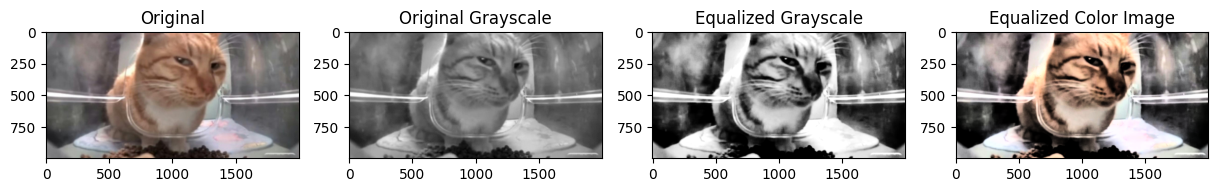

In [12]:
# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(original_image)
plt.subplot(1, 4, 2)
plt.title("Original Grayscale")
plt.imshow(original_gray, cmap="gray")
plt.subplot(1, 4, 3)
plt.title("Equalized Grayscale")
plt.imshow(equalized_gray, cmap="gray")
plt.subplot(1, 4, 4)
plt.title("Equalized Color Image")
plt.imshow(result_image)
plt.show()

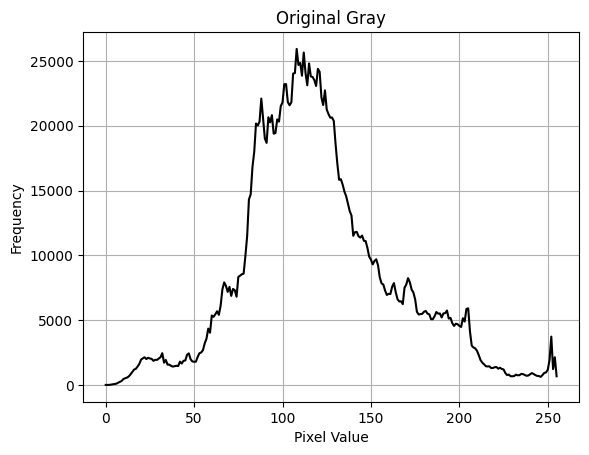

In [13]:
hist1 = compute_histogram(original_gray)
plt.plot(hist1, color='black')
plt.title("Original Gray")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

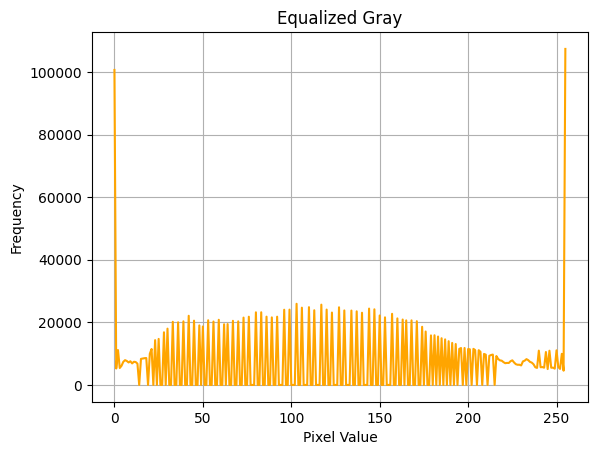

In [14]:
hist2 = compute_histogram(equalized_gray)
plt.plot(hist2, color='orange')
plt.title("Equalized Gray")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

Note:
    # plt.plot(hist, color='black')
    # plt.title("Grayscale Histogram")
    # plt.xlabel("Pixel Value")
    # plt.ylabel("Frequency")
    # plt.grid()
    # plt.show()